In [ ]:
!pip install super-gradients

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 63.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 99.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 104.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 96.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 59.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setu

##WorkingModel

In [ ]:
from google.colab import drive
import os

# Mount Google Drive if not already mounted
drive.mount('/content/drive', force_remount=True)

# Specify the path to check
path_to_check = "/content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/DATASET"

def explore_directory(path, indent=""):
    """Recursively explore the directory and print its contents."""
    print(f"{indent}{os.path.basename(path)}/")
    indent += "  "
    try:
        for item in sorted(os.listdir(path)):
            item_path = os.path.join(path, item)
            if os.path.isdir(item_path):
                explore_directory(item_path, indent)
            else:
                print(f"{indent}{item}")
    except PermissionError:
        print(f"{indent}Permission denied to access this directory.")

def count_files(path):
    """Count the number of files in the directory and its subdirectories."""
    total_files = 0
    for root, dirs, files in os.walk(path):
        total_files += len(files)
    return total_files

# Check if the path exists
if os.path.exists(path_to_check):
    print(f"Contents of {path_to_check}:")
    explore_directory(path_to_check)

    total_files = count_files(path_to_check)
    print(f"\nTotal number of files: {total_files}")

    # Check for specific subdirectories
    expected_dirs = ['train', 'valid', 'test']
    for dir_name in expected_dirs:
        dir_path = os.path.join(path_to_check, "Surya_Weapons_Detection-1", dir_name)
        if os.path.exists(dir_path):
            print(f"\nContents of {dir_name} directory:")
            print(f"  Images: {len(os.listdir(os.path.join(dir_path, 'images')))} files")
            print(f"  Labels: {len(os.listdir(os.path.join(dir_path, 'labels')))} files")
        else:
            print(f"\n{dir_name} directory not found.")
else:
    print(f"The path {path_to_check} does not exist.")

In [ ]:
import torch
import os
import logging
from concurrent.futures import ThreadPoolExecutor
from super_gradients.training import Trainer
from super_gradients.training import models
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050, DetectionMetrics_050_095
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def verify_image_label_pairs(image_dir, label_dir):
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    valid_pairs = []

    for img_file in image_files:
        label_file = img_file.rsplit('.', 1)[0] + '.txt'
        if os.path.exists(os.path.join(label_dir, label_file)):
            valid_pairs.append(img_file)

    logging.info(f"Found {len(valid_pairs)} valid image-label pairs in {image_dir}")
    return valid_pairs

# 2. Update the process_dataset function
def process_dataset(data_dir, images_dir, labels_dir):
    image_dir = os.path.join(data_dir, images_dir)
    label_dir = os.path.join(data_dir, labels_dir)

    logging.info(f"Processing dataset in {image_dir} and {label_dir}")
    valid_pairs = verify_image_label_pairs(image_dir, label_dir)

    return len(valid_pairs), images_dir, labels_dir

# Set up paths
data_dir = '/content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/DATASET/Surya_Weapons_Detection-1'
train_images_dir = 'train/images'
train_labels_dir = 'train/labels'
val_images_dir = 'valid/images'
val_labels_dir = 'valid/labels'

# Set up trainer
CHECKPOINT_DIR = '/content/drive/MyDrive/Coventry_Final_Year_Projects/Surya'
trainer = Trainer(experiment_name='handgun_detection_yolo_nas-surya_Final_v2', ckpt_root_dir=CHECKPOINT_DIR)

# Dataset parameters
dataset_params = {
    'data_dir': data_dir,
    'train_images_dir': train_images_dir,
    'train_labels_dir': train_labels_dir,
    'val_images_dir': val_images_dir,
    'val_labels_dir': val_labels_dir,
    'classes': ['handgun','knife']
}

# Process datasets
# 3. Update the dataset processing part
with ThreadPoolExecutor() as executor:
    future_train = executor.submit(process_dataset, data_dir, train_images_dir, train_labels_dir)
    future_val = executor.submit(process_dataset, data_dir, val_images_dir, val_labels_dir)

    train_count, train_images_dir, train_labels_dir = future_train.result()
    val_count, val_images_dir, val_labels_dir = future_val.result()

logging.info(f"Training set: {train_count} valid image-label pairs")
logging.info(f"Validation set: {val_count} valid image-label pairs")

# Prepare data loaders
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': train_images_dir,
        'labels_dir': train_labels_dir,
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': 32,
        'num_workers': 2,
        'pin_memory': True
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': val_images_dir,
        'labels_dir': val_labels_dir,
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size': 32,
        'num_workers': 2,
        'pin_memory': True
    }
)

# Initialize model
model = models.get('yolo_nas_l',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco")

# Training parameters
train_params = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'silent_mode': False,  # Changed to False for more verbose output
    "average_best_models": True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": 50,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

# Start training
logging.info("Starting training...")
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)
logging.info("Training completed.")

# Function to find the most recent run directory
def find_latest_run(base_dir):
    run_dirs = [d for d in os.listdir(base_dir) if d.startswith('RUN_')]
    if not run_dirs:
        return None
    return max(run_dirs)

# Construct the path to the experiment directory
exp_dir = os.path.join(CHECKPOINT_DIR, 'handgun_detection_yolo_nas')
logging.info(f"Experiment directory: {exp_dir}")

# Find the latest run directory
latest_run = find_latest_run(exp_dir)
if latest_run:
    run_dir = os.path.join(exp_dir, latest_run)
    logging.info(f"Latest run directory found: {run_dir}")

    # Construct the full path for the best checkpoint
    best_ckpt_path = os.path.join(run_dir, 'ckpt_best.pth')
    logging.info(f"Best checkpoint path: {best_ckpt_path}")

    # Check if the checkpoint file exists
    if os.path.exists(best_ckpt_path):
        logging.info(f"Best checkpoint file found at {best_ckpt_path}")
        # Load best model
        try:
            best_model = models.get('yolo_nas_l',
                                    num_classes=len(dataset_params['classes']),
                                    checkpoint_path=best_ckpt_path)
            logging.info("Best model loaded successfully.")

            # Save the model
            save_path = os.path.join(CHECKPOINT_DIR, 'final_handgun_detection_model.pth')
            torch.save(best_model.state_dict(), save_path)
            logging.info(f"Model saved to {save_path}")
        except Exception as e:
            logging.error(f"Error loading the best model: {str(e)}")
    else:
        logging.error(f"Best checkpoint file not found at {best_ckpt_path}")
else:
    logging.error(f"No run directories found in {exp_dir}")

logging.info("Script execution completed.")

[2024-07-20 03:57:04] INFO - <ipython-input-2-9190f4f84dcd> - Processing dataset in /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/DATASET/Surya_Weapons_Detection-1/train/images and /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/DATASET/Surya_Weapons_Detection-1/train/labels
[2024-07-20 03:57:04] INFO - <ipython-input-2-9190f4f84dcd> - Processing dataset in /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/DATASET/Surya_Weapons_Detection-1/valid/images and /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/DATASET/Surya_Weapons_Detection-1/valid/labels
[2024-07-20 03:57:12] INFO - <ipython-input-2-9190f4f84dcd> - Found 3000 valid image-label pairs in /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/DATASET/Surya_Weapons_Detection-1/valid/images
[2024-07-20 03:57:14] INFO - <ipython-input-2-9190f4f84dcd> - Found 12060 valid image-label pairs in /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/DATASET/Surya_Weapons_Detection-1/train/

The console stream is now moved to /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/handgun_detection_yolo_nas-surya_Final_v2/RUN_20240720_052815_041870/console_Jul20_05_28_15.txt


/usr/local/lib/python3.10/dist-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/optimizer_utils.py:108: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
  warnings.warn(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.7978
│   ├── Ppyoloeloss/loss_iou = 0.638
│   ├── Ppyoloeloss/loss_dfl = 0.8179
│   └── Ppyoloeloss/loss = 3.2538
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.7603
    ├── Ppyoloeloss/loss_iou = 0.5549
    ├── Ppyoloeloss/loss_dfl = 0.7822
    ├── Ppyoloeloss/loss = 3.0974
    ├── Precision@0.50 = 0.0106
    ├── Recall@0.50 = 0.3096
    ├── Map@0.50 = 0.1178
    ├── F1@0.50 = 0.0205
    ├── Best_score_threshold = 0.51
    ├── Precision@0.50:0.95 = 0.0074
    ├── Recall@0.50:0.95 = 0.2167
    ├── Map@0.50:0.95 = 0.0758
    └── F1@0.50:0.95 = 0.0144



Validating epoch 1: 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]
[2024-07-20 05:50:54] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/handgun_detection_yolo_nas-surya_Final_v2/RUN_20240720_052815_041870/ckpt_best.pth
[2024-07-20 05:50:54] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.48433810472488403


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1889
│   │   ├── Epoch N-1      = 1.7978 (↘ -0.609)
│   │   └── Best until now = 1.7978 (↘ -0.609)
│   ├── Ppyoloeloss/loss_iou = 0.5309
│   │   ├── Epoch N-1      = 0.638  (↘ -0.1072)
│   │   └── Best until now = 0.638  (↘ -0.1072)
│   ├── Ppyoloeloss/loss_dfl = 0.7063
│   │   ├── Epoch N-1      = 0.8179 (↘ -0.1116)
│   │   └── Best until now = 0.8179 (↘ -0.1116)
│   └── Ppyoloeloss/loss = 2.426
│       ├── Epoch N-1      = 3.2538 (↘ -0.8278)
│       └── Best until now = 3.2538 (↘ -0.8278)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1988
    │   ├── Epoch N-1      = 1.7603 (↘ -0.5616)
    │   └── Best until now = 1.7603 (↘ -0.5616)
    ├── Ppyoloeloss/loss_iou = 0.4754
    │   ├── Epoch N-1      = 0.5549 (↘ -0.0795)
    │   └── Best until now = 0.5549 (↘ -0.0795)
    ├── Ppyoloeloss/loss_dfl = 0.6832
    │   ├── Epoch N-1      = 0.7822 (↘ -0.099)
    │   └── Best until now = 0.7822 (↘ -0.099)
    ├── Ppyoloeloss/loss = 

Validating epoch 2: 100%|██████████| 94/94 [01:31<00:00,  1.02it/s]


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1458
│   │   ├── Epoch N-1      = 1.1889 (↘ -0.043)
│   │   └── Best until now = 1.1889 (↘ -0.043)
│   ├── Ppyoloeloss/loss_iou = 0.5267
│   │   ├── Epoch N-1      = 0.5309 (↘ -0.0042)
│   │   └── Best until now = 0.5309 (↘ -0.0042)
│   ├── Ppyoloeloss/loss_dfl = 0.6943
│   │   ├── Epoch N-1      = 0.7063 (↘ -0.012)
│   │   └── Best until now = 0.7063 (↘ -0.012)
│   └── Ppyoloeloss/loss = 2.3669
│       ├── Epoch N-1      = 2.426  (↘ -0.0592)
│       └── Best until now = 2.426  (↘ -0.0592)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2971
    │   ├── Epoch N-1      = 1.1988 (↗ 0.0984)
    │   └── Best until now = 1.1988 (↗ 0.0984)
    ├── Ppyoloeloss/loss_iou = 0.5064
    │   ├── Epoch N-1      = 0.4754 (↗ 0.031)
    │   └── Best until now = 0.4754 (↗ 0.031)
    ├── Ppyoloeloss/loss_dfl = 0.6922
    │   ├── Epoch N-1      = 0.6832 (↗ 0.009)
    │   └── Best until now = 0.6832 (↗ 0.009)
    ├── Ppyoloeloss/loss = 2.4958
  

Validating epoch 3: 100%|██████████| 94/94 [01:31<00:00,  1.03it/s]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1498
│   │   ├── Epoch N-1      = 1.1458 (↗ 0.004)
│   │   └── Best until now = 1.1458 (↗ 0.004)
│   ├── Ppyoloeloss/loss_iou = 0.5254
│   │   ├── Epoch N-1      = 0.5267 (↘ -0.0013)
│   │   └── Best until now = 0.5267 (↘ -0.0013)
│   ├── Ppyoloeloss/loss_dfl = 0.6964
│   │   ├── Epoch N-1      = 0.6943 (↗ 0.002)
│   │   └── Best until now = 0.6943 (↗ 0.002)
│   └── Ppyoloeloss/loss = 2.3716
│       ├── Epoch N-1      = 2.3669 (↗ 0.0047)
│       └── Best until now = 2.3669 (↗ 0.0047)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.234
    │   ├── Epoch N-1      = 1.2971 (↘ -0.0631)
    │   └── Best until now = 1.1988 (↗ 0.0353)
    ├── Ppyoloeloss/loss_iou = 0.5297
    │   ├── Epoch N-1      = 0.5064 (↗ 0.0232)
    │   └── Best until now = 0.4754 (↗ 0.0543)
    ├── Ppyoloeloss/loss_dfl = 0.7186
    │   ├── Epoch N-1      = 0.6922 (↗ 0.0263)
    │   └── Best until now = 0.6832 (↗ 0.0354)
    ├── Ppyoloeloss/loss = 2.4823
    

Validating epoch 4: 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1218
│   │   ├── Epoch N-1      = 1.1498 (↘ -0.028)
│   │   └── Best until now = 1.1458 (↘ -0.0241)
│   ├── Ppyoloeloss/loss_iou = 0.509
│   │   ├── Epoch N-1      = 0.5254 (↘ -0.0165)
│   │   └── Best until now = 0.5254 (↘ -0.0165)
│   ├── Ppyoloeloss/loss_dfl = 0.6774
│   │   ├── Epoch N-1      = 0.6964 (↘ -0.019)
│   │   └── Best until now = 0.6943 (↘ -0.017)
│   └── Ppyoloeloss/loss = 2.3081
│       ├── Epoch N-1      = 2.3716 (↘ -0.0635)
│       └── Best until now = 2.3669 (↘ -0.0588)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3981
    │   ├── Epoch N-1      = 1.234  (↗ 0.1641)
    │   └── Best until now = 1.1988 (↗ 0.1994)
    ├── Ppyoloeloss/loss_iou = 0.504
    │   ├── Epoch N-1      = 0.5297 (↘ -0.0257)
    │   └── Best until now = 0.4754 (↗ 0.0286)
    ├── Ppyoloeloss/loss_dfl = 0.7051
    │   ├── Epoch N-1      = 0.7186 (↘ -0.0135)
    │   └── Best until now = 0.6832 (↗ 0.0219)
    ├── Ppyoloeloss/loss = 2.60

Validating epoch 5: 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]
[2024-07-20 06:35:20] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/handgun_detection_yolo_nas-surya_Final_v2/RUN_20240720_052815_041870/ckpt_best.pth
[2024-07-20 06:35:20] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.5238076448440552


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.111
│   │   ├── Epoch N-1      = 1.1218 (↘ -0.0108)
│   │   └── Best until now = 1.1218 (↘ -0.0108)
│   ├── Ppyoloeloss/loss_iou = 0.5023
│   │   ├── Epoch N-1      = 0.509  (↘ -0.0067)
│   │   └── Best until now = 0.509  (↘ -0.0067)
│   ├── Ppyoloeloss/loss_dfl = 0.6702
│   │   ├── Epoch N-1      = 0.6774 (↘ -0.0071)
│   │   └── Best until now = 0.6774 (↘ -0.0071)
│   └── Ppyoloeloss/loss = 2.2835
│       ├── Epoch N-1      = 2.3081 (↘ -0.0246)
│       └── Best until now = 2.3081 (↘ -0.0246)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3098
    │   ├── Epoch N-1      = 1.3981 (↘ -0.0883)
    │   └── Best until now = 1.1988 (↗ 0.1111)
    ├── Ppyoloeloss/loss_iou = 0.4892
    │   ├── Epoch N-1      = 0.504  (↘ -0.0148)
    │   └── Best until now = 0.4754 (↗ 0.0137)
    ├── Ppyoloeloss/loss_dfl = 0.6888
    │   ├── Epoch N-1      = 0.7051 (↘ -0.0163)
    │   └── Best until now = 0.6832 (↗ 0.0056)
    ├── Ppyoloeloss/loss =

Validating epoch 6: 100%|██████████| 94/94 [01:31<00:00,  1.02it/s]
[2024-07-20 06:46:29] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/handgun_detection_yolo_nas-surya_Final_v2/RUN_20240720_052815_041870/ckpt_best.pth
[2024-07-20 06:46:29] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.5426930785179138


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.1025
│   │   ├── Epoch N-1      = 1.111  (↘ -0.0085)
│   │   └── Best until now = 1.111  (↘ -0.0085)
│   ├── Ppyoloeloss/loss_iou = 0.4955
│   │   ├── Epoch N-1      = 0.5023 (↘ -0.0068)
│   │   └── Best until now = 0.5023 (↘ -0.0068)
│   ├── Ppyoloeloss/loss_dfl = 0.6652
│   │   ├── Epoch N-1      = 0.6702 (↘ -0.0051)
│   │   └── Best until now = 0.6702 (↘ -0.0051)
│   └── Ppyoloeloss/loss = 2.2632
│       ├── Epoch N-1      = 2.2835 (↘ -0.0203)
│       └── Best until now = 2.2835 (↘ -0.0203)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.3814
    │   ├── Epoch N-1      = 1.3098 (↗ 0.0715)
    │   └── Best until now = 1.1988 (↗ 0.1826)
    ├── Ppyoloeloss/loss_iou = 0.4928
    │   ├── Epoch N-1      = 0.4892 (↗ 0.0037)
    │   └── Best until now = 0.4754 (↗ 0.0174)
    ├── Ppyoloeloss/loss_dfl = 0.6865
    │   ├── Epoch N-1      = 0.6888 (↘ -0.0024)
    │   └── Best until now = 0.6832 (↗ 0.0033)
    ├── Ppyoloeloss/loss = 

Validating epoch 7: 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]
[2024-07-20 06:57:42] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/handgun_detection_yolo_nas-surya_Final_v2/RUN_20240720_052815_041870/ckpt_best.pth
[2024-07-20 06:57:42] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.5444719195365906


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0853
│   │   ├── Epoch N-1      = 1.1025 (↘ -0.0172)
│   │   └── Best until now = 1.1025 (↘ -0.0172)
│   ├── Ppyoloeloss/loss_iou = 0.4892
│   │   ├── Epoch N-1      = 0.4955 (↘ -0.0063)
│   │   └── Best until now = 0.4955 (↘ -0.0063)
│   ├── Ppyoloeloss/loss_dfl = 0.657
│   │   ├── Epoch N-1      = 0.6652 (↘ -0.0081)
│   │   └── Best until now = 0.6652 (↘ -0.0081)
│   └── Ppyoloeloss/loss = 2.2315
│       ├── Epoch N-1      = 2.2632 (↘ -0.0316)
│       └── Best until now = 2.2632 (↘ -0.0316)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.239
    │   ├── Epoch N-1      = 1.3814 (↘ -0.1423)
    │   └── Best until now = 1.1988 (↗ 0.0403)
    ├── Ppyoloeloss/loss_iou = 0.4829
    │   ├── Epoch N-1      = 0.4928 (↘ -0.01)
    │   └── Best until now = 0.4754 (↗ 0.0074)
    ├── Ppyoloeloss/loss_dfl = 0.6689
    │   ├── Epoch N-1      = 0.6865 (↘ -0.0176)
    │   └── Best until now = 0.6832 (↘ -0.0143)
    ├── Ppyoloeloss/loss = 2

Validating epoch 8: 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]
[2024-07-20 07:08:55] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/handgun_detection_yolo_nas-surya_Final_v2/RUN_20240720_052815_041870/ckpt_best.pth
[2024-07-20 07:08:55] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6039921045303345


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0808
│   │   ├── Epoch N-1      = 1.0853 (↘ -0.0045)
│   │   └── Best until now = 1.0853 (↘ -0.0045)
│   ├── Ppyoloeloss/loss_iou = 0.4879
│   │   ├── Epoch N-1      = 0.4892 (↘ -0.0012)
│   │   └── Best until now = 0.4892 (↘ -0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.655
│   │   ├── Epoch N-1      = 0.657  (↘ -0.002)
│   │   └── Best until now = 0.657  (↘ -0.002)
│   └── Ppyoloeloss/loss = 2.2238
│       ├── Epoch N-1      = 2.2315 (↘ -0.0078)
│       └── Best until now = 2.2315 (↘ -0.0078)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1037
    │   ├── Epoch N-1      = 1.239  (↘ -0.1354)
    │   └── Best until now = 1.1988 (↘ -0.0951)
    ├── Ppyoloeloss/loss_iou = 0.4892
    │   ├── Epoch N-1      = 0.4829 (↗ 0.0063)
    │   └── Best until now = 0.4754 (↗ 0.0138)
    ├── Ppyoloeloss/loss_dfl = 0.6559
    │   ├── Epoch N-1      = 0.6689 (↘ -0.013)
    │   └── Best until now = 0.6689 (↘ -0.013)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 9: 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0786
│   │   ├── Epoch N-1      = 1.0808 (↘ -0.0022)
│   │   └── Best until now = 1.0808 (↘ -0.0022)
│   ├── Ppyoloeloss/loss_iou = 0.4838
│   │   ├── Epoch N-1      = 0.4879 (↘ -0.0041)
│   │   └── Best until now = 0.4879 (↘ -0.0041)
│   ├── Ppyoloeloss/loss_dfl = 0.6517
│   │   ├── Epoch N-1      = 0.655  (↘ -0.0033)
│   │   └── Best until now = 0.655  (↘ -0.0033)
│   └── Ppyoloeloss/loss = 2.2141
│       ├── Epoch N-1      = 2.2238 (↘ -0.0097)
│       └── Best until now = 2.2238 (↘ -0.0097)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2625
    │   ├── Epoch N-1      = 1.1037 (↗ 0.1588)
    │   └── Best until now = 1.1037 (↗ 0.1588)
    ├── Ppyoloeloss/loss_iou = 0.4922
    │   ├── Epoch N-1      = 0.4892 (↗ 0.003)
    │   └── Best until now = 0.4754 (↗ 0.0168)
    ├── Ppyoloeloss/loss_dfl = 0.6878
    │   ├── Epoch N-1      = 0.6559 (↗ 0.0319)
    │   └── Best until now = 0.6559 (↗ 0.0319)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 10: 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0734
│   │   ├── Epoch N-1      = 1.0786 (↘ -0.0052)
│   │   └── Best until now = 1.0786 (↘ -0.0052)
│   ├── Ppyoloeloss/loss_iou = 0.4818
│   │   ├── Epoch N-1      = 0.4838 (↘ -0.002)
│   │   └── Best until now = 0.4838 (↘ -0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.6505
│   │   ├── Epoch N-1      = 0.6517 (↘ -0.0012)
│   │   └── Best until now = 0.6517 (↘ -0.0012)
│   └── Ppyoloeloss/loss = 2.2057
│       ├── Epoch N-1      = 2.2141 (↘ -0.0084)
│       └── Best until now = 2.2141 (↘ -0.0084)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1634
    │   ├── Epoch N-1      = 1.2625 (↘ -0.0991)
    │   └── Best until now = 1.1037 (↗ 0.0597)
    ├── Ppyoloeloss/loss_iou = 0.4756
    │   ├── Epoch N-1      = 0.4922 (↘ -0.0166)
    │   └── Best until now = 0.4754 (↗ 0.0002)
    ├── Ppyoloeloss/loss_dfl = 0.6671
    │   ├── Epoch N-1      = 0.6878 (↘ -0.0206)
    │   └── Best until now = 0.6559 (↗ 0.0112)
    ├── Ppyoloeloss/loss =

Validating epoch 11: 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0702
│   │   ├── Epoch N-1      = 1.0734 (↘ -0.0032)
│   │   └── Best until now = 1.0734 (↘ -0.0032)
│   ├── Ppyoloeloss/loss_iou = 0.4816
│   │   ├── Epoch N-1      = 0.4818 (↘ -0.0003)
│   │   └── Best until now = 0.4818 (↘ -0.0003)
│   ├── Ppyoloeloss/loss_dfl = 0.6476
│   │   ├── Epoch N-1      = 0.6505 (↘ -0.0029)
│   │   └── Best until now = 0.6505 (↘ -0.0029)
│   └── Ppyoloeloss/loss = 2.1993
│       ├── Epoch N-1      = 2.2057 (↘ -0.0064)
│       └── Best until now = 2.2057 (↘ -0.0064)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.326
    │   ├── Epoch N-1      = 1.1634 (↗ 0.1627)
    │   └── Best until now = 1.1037 (↗ 0.2224)
    ├── Ppyoloeloss/loss_iou = 0.4705
    │   ├── Epoch N-1      = 0.4756 (↘ -0.0051)
    │   └── Best until now = 0.4754 (↘ -0.0049)
    ├── Ppyoloeloss/loss_dfl = 0.6626
    │   ├── Epoch N-1      = 0.6671 (↘ -0.0045)
    │   └── Best until now = 0.6559 (↗ 0.0067)
    ├── Ppyoloeloss/loss 

Validating epoch 12: 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0663
│   │   ├── Epoch N-1      = 1.0702 (↘ -0.0038)
│   │   └── Best until now = 1.0702 (↘ -0.0038)
│   ├── Ppyoloeloss/loss_iou = 0.4787
│   │   ├── Epoch N-1      = 0.4816 (↘ -0.0028)
│   │   └── Best until now = 0.4816 (↘ -0.0028)
│   ├── Ppyoloeloss/loss_dfl = 0.6461
│   │   ├── Epoch N-1      = 0.6476 (↘ -0.0015)
│   │   └── Best until now = 0.6476 (↘ -0.0015)
│   └── Ppyoloeloss/loss = 2.1912
│       ├── Epoch N-1      = 2.1993 (↘ -0.0082)
│       └── Best until now = 2.1993 (↘ -0.0082)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1916
    │   ├── Epoch N-1      = 1.326  (↘ -0.1344)
    │   └── Best until now = 1.1037 (↗ 0.088)
    ├── Ppyoloeloss/loss_iou = 0.4854
    │   ├── Epoch N-1      = 0.4705 (↗ 0.0149)
    │   └── Best until now = 0.4705 (↗ 0.0149)
    ├── Ppyoloeloss/loss_dfl = 0.6855
    │   ├── Epoch N-1      = 0.6626 (↗ 0.023)
    │   └── Best until now = 0.6559 (↗ 0.0297)
    ├── Ppyoloeloss/loss = 2

Validating epoch 13: 100%|██████████| 94/94 [01:31<00:00,  1.02it/s]


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.067
│   │   ├── Epoch N-1      = 1.0663 (↗ 0.0007)
│   │   └── Best until now = 1.0663 (↗ 0.0007)
│   ├── Ppyoloeloss/loss_iou = 0.4788
│   │   ├── Epoch N-1      = 0.4787 (↗ 1e-04)
│   │   └── Best until now = 0.4787 (↗ 1e-04)
│   ├── Ppyoloeloss/loss_dfl = 0.6448
│   │   ├── Epoch N-1      = 0.6461 (↘ -0.0013)
│   │   └── Best until now = 0.6461 (↘ -0.0013)
│   └── Ppyoloeloss/loss = 2.1906
│       ├── Epoch N-1      = 2.1912 (↘ -0.0006)
│       └── Best until now = 2.1912 (↘ -0.0006)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2217
    │   ├── Epoch N-1      = 1.1916 (↗ 0.03)
    │   └── Best until now = 1.1037 (↗ 0.118)
    ├── Ppyoloeloss/loss_iou = 0.4737
    │   ├── Epoch N-1      = 0.4854 (↘ -0.0118)
    │   └── Best until now = 0.4705 (↗ 0.0031)
    ├── Ppyoloeloss/loss_dfl = 0.6724
    │   ├── Epoch N-1      = 0.6855 (↘ -0.0131)
    │   └── Best until now = 0.6559 (↗ 0.0165)
    ├── Ppyoloeloss/loss = 2.3678
 

Validating epoch 14: 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0589
│   │   ├── Epoch N-1      = 1.067  (↘ -0.0081)
│   │   └── Best until now = 1.0663 (↘ -0.0074)
│   ├── Ppyoloeloss/loss_iou = 0.4731
│   │   ├── Epoch N-1      = 0.4788 (↘ -0.0057)
│   │   └── Best until now = 0.4787 (↘ -0.0056)
│   ├── Ppyoloeloss/loss_dfl = 0.6423
│   │   ├── Epoch N-1      = 0.6448 (↘ -0.0025)
│   │   └── Best until now = 0.6448 (↘ -0.0025)
│   └── Ppyoloeloss/loss = 2.1742
│       ├── Epoch N-1      = 2.1906 (↘ -0.0163)
│       └── Best until now = 2.1906 (↘ -0.0163)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2494
    │   ├── Epoch N-1      = 1.2217 (↗ 0.0277)
    │   └── Best until now = 1.1037 (↗ 0.1457)
    ├── Ppyoloeloss/loss_iou = 0.4822
    │   ├── Epoch N-1      = 0.4737 (↗ 0.0086)
    │   └── Best until now = 0.4705 (↗ 0.0117)
    ├── Ppyoloeloss/loss_dfl = 0.6825
    │   ├── Epoch N-1      = 0.6724 (↗ 0.01)
    │   └── Best until now = 0.6559 (↗ 0.0266)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 15: 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0532
│   │   ├── Epoch N-1      = 1.0589 (↘ -0.0056)
│   │   └── Best until now = 1.0589 (↘ -0.0056)
│   ├── Ppyoloeloss/loss_iou = 0.4721
│   │   ├── Epoch N-1      = 0.4731 (↘ -0.001)
│   │   └── Best until now = 0.4731 (↘ -0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.6421
│   │   ├── Epoch N-1      = 0.6423 (↘ -0.0002)
│   │   └── Best until now = 0.6423 (↘ -0.0002)
│   └── Ppyoloeloss/loss = 2.1674
│       ├── Epoch N-1      = 2.1742 (↘ -0.0068)
│       └── Best until now = 2.1742 (↘ -0.0068)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1935
    │   ├── Epoch N-1      = 1.2494 (↘ -0.0558)
    │   └── Best until now = 1.1037 (↗ 0.0898)
    ├── Ppyoloeloss/loss_iou = 0.4726
    │   ├── Epoch N-1      = 0.4822 (↘ -0.0096)
    │   └── Best until now = 0.4705 (↗ 0.0021)
    ├── Ppyoloeloss/loss_dfl = 0.6573
    │   ├── Epoch N-1      = 0.6825 (↘ -0.0252)
    │   └── Best until now = 0.6559 (↗ 0.0014)
    ├── Ppyoloeloss/loss =

Validating epoch 16: 100%|██████████| 94/94 [01:31<00:00,  1.02it/s]


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0505
│   │   ├── Epoch N-1      = 1.0532 (↘ -0.0028)
│   │   └── Best until now = 1.0532 (↘ -0.0028)
│   ├── Ppyoloeloss/loss_iou = 0.4717
│   │   ├── Epoch N-1      = 0.4721 (↘ -0.0004)
│   │   └── Best until now = 0.4721 (↘ -0.0004)
│   ├── Ppyoloeloss/loss_dfl = 0.6381
│   │   ├── Epoch N-1      = 0.6421 (↘ -0.0041)
│   │   └── Best until now = 0.6421 (↘ -0.0041)
│   └── Ppyoloeloss/loss = 2.1602
│       ├── Epoch N-1      = 2.1674 (↘ -0.0072)
│       └── Best until now = 2.1674 (↘ -0.0072)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2093
    │   ├── Epoch N-1      = 1.1935 (↗ 0.0157)
    │   └── Best until now = 1.1037 (↗ 0.1056)
    ├── Ppyoloeloss/loss_iou = 0.4682
    │   ├── Epoch N-1      = 0.4726 (↘ -0.0044)
    │   └── Best until now = 0.4705 (↘ -0.0023)
    ├── Ppyoloeloss/loss_dfl = 0.6626
    │   ├── Epoch N-1      = 0.6573 (↗ 0.0053)
    │   └── Best until now = 0.6559 (↗ 0.0067)
    ├── Ppyoloeloss/loss 

Validating epoch 17: 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]
[2024-07-20 08:50:06] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/handgun_detection_yolo_nas-surya_Final_v2/RUN_20240720_052815_041870/ckpt_best.pth
[2024-07-20 08:50:06] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6407114267349243


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0477
│   │   ├── Epoch N-1      = 1.0505 (↘ -0.0027)
│   │   └── Best until now = 1.0505 (↘ -0.0027)
│   ├── Ppyoloeloss/loss_iou = 0.4675
│   │   ├── Epoch N-1      = 0.4717 (↘ -0.0041)
│   │   └── Best until now = 0.4717 (↘ -0.0041)
│   ├── Ppyoloeloss/loss_dfl = 0.6372
│   │   ├── Epoch N-1      = 0.6381 (↘ -0.0009)
│   │   └── Best until now = 0.6381 (↘ -0.0009)
│   └── Ppyoloeloss/loss = 2.1524
│       ├── Epoch N-1      = 2.1602 (↘ -0.0078)
│       └── Best until now = 2.1602 (↘ -0.0078)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1239
    │   ├── Epoch N-1      = 1.2093 (↘ -0.0854)
    │   └── Best until now = 1.1037 (↗ 0.0202)
    ├── Ppyoloeloss/loss_iou = 0.4587
    │   ├── Epoch N-1      = 0.4682 (↘ -0.0095)
    │   └── Best until now = 0.4682 (↘ -0.0095)
    ├── Ppyoloeloss/loss_dfl = 0.6462
    │   ├── Epoch N-1      = 0.6626 (↘ -0.0164)
    │   └── Best until now = 0.6559 (↘ -0.0097)
    ├── Ppyoloeloss/lo

Validating epoch 18: 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0355
│   │   ├── Epoch N-1      = 1.0477 (↘ -0.0122)
│   │   └── Best until now = 1.0477 (↘ -0.0122)
│   ├── Ppyoloeloss/loss_iou = 0.4653
│   │   ├── Epoch N-1      = 0.4675 (↘ -0.0023)
│   │   └── Best until now = 0.4675 (↘ -0.0023)
│   ├── Ppyoloeloss/loss_dfl = 0.6305
│   │   ├── Epoch N-1      = 0.6372 (↘ -0.0066)
│   │   └── Best until now = 0.6372 (↘ -0.0066)
│   └── Ppyoloeloss/loss = 2.1313
│       ├── Epoch N-1      = 2.1524 (↘ -0.0211)
│       └── Best until now = 2.1524 (↘ -0.0211)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.232
    │   ├── Epoch N-1      = 1.1239 (↗ 0.1081)
    │   └── Best until now = 1.1037 (↗ 0.1283)
    ├── Ppyoloeloss/loss_iou = 0.4694
    │   ├── Epoch N-1      = 0.4587 (↗ 0.0107)
    │   └── Best until now = 0.4587 (↗ 0.0107)
    ├── Ppyoloeloss/loss_dfl = 0.66
    │   ├── Epoch N-1      = 0.6462 (↗ 0.0138)
    │   └── Best until now = 0.6462 (↗ 0.0138)
    ├── Ppyoloeloss/loss = 2.3

Validating epoch 19: 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0359
│   │   ├── Epoch N-1      = 1.0355 (↗ 0.0004)
│   │   └── Best until now = 1.0355 (↗ 0.0004)
│   ├── Ppyoloeloss/loss_iou = 0.4641
│   │   ├── Epoch N-1      = 0.4653 (↘ -0.0012)
│   │   └── Best until now = 0.4653 (↘ -0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.6302
│   │   ├── Epoch N-1      = 0.6305 (↘ -0.0003)
│   │   └── Best until now = 0.6305 (↘ -0.0003)
│   └── Ppyoloeloss/loss = 2.1302
│       ├── Epoch N-1      = 2.1313 (↘ -0.0011)
│       └── Best until now = 2.1313 (↘ -0.0011)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2425
    │   ├── Epoch N-1      = 1.232  (↗ 0.0105)
    │   └── Best until now = 1.1037 (↗ 0.1388)
    ├── Ppyoloeloss/loss_iou = 0.4744
    │   ├── Epoch N-1      = 0.4694 (↗ 0.005)
    │   └── Best until now = 0.4587 (↗ 0.0157)
    ├── Ppyoloeloss/loss_dfl = 0.6533
    │   ├── Epoch N-1      = 0.66   (↘ -0.0067)
    │   └── Best until now = 0.6462 (↗ 0.0071)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 20: 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]
[2024-07-20 09:23:55] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/handgun_detection_yolo_nas-surya_Final_v2/RUN_20240720_052815_041870/ckpt_best.pth
[2024-07-20 09:23:55] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.6768378019332886


SUMMARY OF EPOCH 20
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.028
│   │   ├── Epoch N-1      = 1.0359 (↘ -0.008)
│   │   └── Best until now = 1.0355 (↘ -0.0075)
│   ├── Ppyoloeloss/loss_iou = 0.4584
│   │   ├── Epoch N-1      = 0.4641 (↘ -0.0057)
│   │   └── Best until now = 0.4641 (↘ -0.0057)
│   ├── Ppyoloeloss/loss_dfl = 0.6249
│   │   ├── Epoch N-1      = 0.6302 (↘ -0.0053)
│   │   └── Best until now = 0.6302 (↘ -0.0053)
│   └── Ppyoloeloss/loss = 2.1113
│       ├── Epoch N-1      = 2.1302 (↘ -0.019)
│       └── Best until now = 2.1302 (↘ -0.019)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0953
    │   ├── Epoch N-1      = 1.2425 (↘ -0.1472)
    │   └── Best until now = 1.1037 (↘ -0.0084)
    ├── Ppyoloeloss/loss_iou = 0.4435
    │   ├── Epoch N-1      = 0.4744 (↘ -0.0309)
    │   └── Best until now = 0.4587 (↘ -0.0151)
    ├── Ppyoloeloss/loss_dfl = 0.6363
    │   ├── Epoch N-1      = 0.6533 (↘ -0.0169)
    │   └── Best until now = 0.6462 (↘ -0.0099)
    ├── Ppyoloeloss/loss 

Validating epoch 21: 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]


SUMMARY OF EPOCH 21
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0272
│   │   ├── Epoch N-1      = 1.028  (↘ -0.0008)
│   │   └── Best until now = 1.028  (↘ -0.0008)
│   ├── Ppyoloeloss/loss_iou = 0.4588
│   │   ├── Epoch N-1      = 0.4584 (↗ 0.0004)
│   │   └── Best until now = 0.4584 (↗ 0.0004)
│   ├── Ppyoloeloss/loss_dfl = 0.6254
│   │   ├── Epoch N-1      = 0.6249 (↗ 0.0005)
│   │   └── Best until now = 0.6249 (↗ 0.0005)
│   └── Ppyoloeloss/loss = 2.1114
│       ├── Epoch N-1      = 2.1113 (↗ 1e-04)
│       └── Best until now = 2.1113 (↗ 1e-04)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1733
    │   ├── Epoch N-1      = 1.0953 (↗ 0.078)
    │   └── Best until now = 1.0953 (↗ 0.078)
    ├── Ppyoloeloss/loss_iou = 0.4597
    │   ├── Epoch N-1      = 0.4435 (↗ 0.0161)
    │   └── Best until now = 0.4435 (↗ 0.0161)
    ├── Ppyoloeloss/loss_dfl = 0.6487
    │   ├── Epoch N-1      = 0.6363 (↗ 0.0124)
    │   └── Best until now = 0.6363 (↗ 0.0124)
    ├── Ppyoloeloss/loss = 2.2817
   

Validating epoch 22: 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


SUMMARY OF EPOCH 22
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0164
│   │   ├── Epoch N-1      = 1.0272 (↘ -0.0108)
│   │   └── Best until now = 1.0272 (↘ -0.0108)
│   ├── Ppyoloeloss/loss_iou = 0.4573
│   │   ├── Epoch N-1      = 0.4588 (↘ -0.0015)
│   │   └── Best until now = 0.4584 (↘ -0.0011)
│   ├── Ppyoloeloss/loss_dfl = 0.6228
│   │   ├── Epoch N-1      = 0.6254 (↘ -0.0026)
│   │   └── Best until now = 0.6249 (↘ -0.0021)
│   └── Ppyoloeloss/loss = 2.0965
│       ├── Epoch N-1      = 2.1114 (↘ -0.0149)
│       └── Best until now = 2.1113 (↘ -0.0148)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1095
    │   ├── Epoch N-1      = 1.1733 (↘ -0.0639)
    │   └── Best until now = 1.0953 (↗ 0.0142)
    ├── Ppyoloeloss/loss_iou = 0.4588
    │   ├── Epoch N-1      = 0.4597 (↘ -0.0009)
    │   └── Best until now = 0.4435 (↗ 0.0153)
    ├── Ppyoloeloss/loss_dfl = 0.644
    │   ├── Epoch N-1      = 0.6487 (↘ -0.0047)
    │   └── Best until now = 0.6363 (↗ 0.0077)
    ├── Ppyoloeloss/loss 

Validating epoch 23: 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]


SUMMARY OF EPOCH 23
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0142
│   │   ├── Epoch N-1      = 1.0164 (↘ -0.0021)
│   │   └── Best until now = 1.0164 (↘ -0.0021)
│   ├── Ppyoloeloss/loss_iou = 0.4528
│   │   ├── Epoch N-1      = 0.4573 (↘ -0.0045)
│   │   └── Best until now = 0.4573 (↘ -0.0045)
│   ├── Ppyoloeloss/loss_dfl = 0.6198
│   │   ├── Epoch N-1      = 0.6228 (↘ -0.003)
│   │   └── Best until now = 0.6228 (↘ -0.003)
│   └── Ppyoloeloss/loss = 2.0868
│       ├── Epoch N-1      = 2.0965 (↘ -0.0097)
│       └── Best until now = 2.0965 (↘ -0.0097)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1292
    │   ├── Epoch N-1      = 1.1095 (↗ 0.0198)
    │   └── Best until now = 1.0953 (↗ 0.0339)
    ├── Ppyoloeloss/loss_iou = 0.4514
    │   ├── Epoch N-1      = 0.4588 (↘ -0.0073)
    │   └── Best until now = 0.4435 (↗ 0.0079)
    ├── Ppyoloeloss/loss_dfl = 0.6366
    │   ├── Epoch N-1      = 0.644  (↘ -0.0074)
    │   └── Best until now = 0.6363 (↗ 0.0003)
    ├── Ppyoloeloss/loss = 

Validating epoch 24: 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]


SUMMARY OF EPOCH 24
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0097
│   │   ├── Epoch N-1      = 1.0142 (↘ -0.0045)
│   │   └── Best until now = 1.0142 (↘ -0.0045)
│   ├── Ppyoloeloss/loss_iou = 0.4516
│   │   ├── Epoch N-1      = 0.4528 (↘ -0.0011)
│   │   └── Best until now = 0.4528 (↘ -0.0011)
│   ├── Ppyoloeloss/loss_dfl = 0.6148
│   │   ├── Epoch N-1      = 0.6198 (↘ -0.005)
│   │   └── Best until now = 0.6198 (↘ -0.005)
│   └── Ppyoloeloss/loss = 2.0762
│       ├── Epoch N-1      = 2.0868 (↘ -0.0107)
│       └── Best until now = 2.0868 (↘ -0.0107)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0949
    │   ├── Epoch N-1      = 1.1292 (↘ -0.0343)
    │   └── Best until now = 1.0953 (↘ -0.0004)
    ├── Ppyoloeloss/loss_iou = 0.4371
    │   ├── Epoch N-1      = 0.4514 (↘ -0.0144)
    │   └── Best until now = 0.4435 (↘ -0.0064)
    ├── Ppyoloeloss/loss_dfl = 0.6297
    │   ├── Epoch N-1      = 0.6366 (↘ -0.0069)
    │   └── Best until now = 0.6363 (↘ -0.0066)
    ├── Ppyoloeloss/los

Validating epoch 25: 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]
[2024-07-20 10:20:08] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/handgun_detection_yolo_nas-surya_Final_v2/RUN_20240720_052815_041870/ckpt_best.pth
[2024-07-20 10:20:08] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7182555198669434


SUMMARY OF EPOCH 25
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0057
│   │   ├── Epoch N-1      = 1.0097 (↘ -0.004)
│   │   └── Best until now = 1.0097 (↘ -0.004)
│   ├── Ppyoloeloss/loss_iou = 0.4502
│   │   ├── Epoch N-1      = 0.4516 (↘ -0.0014)
│   │   └── Best until now = 0.4516 (↘ -0.0014)
│   ├── Ppyoloeloss/loss_dfl = 0.6144
│   │   ├── Epoch N-1      = 0.6148 (↘ -0.0004)
│   │   └── Best until now = 0.6148 (↘ -0.0004)
│   └── Ppyoloeloss/loss = 2.0703
│       ├── Epoch N-1      = 2.0762 (↘ -0.0059)
│       └── Best until now = 2.0762 (↘ -0.0059)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.04
    │   ├── Epoch N-1      = 1.0949 (↘ -0.055)
    │   └── Best until now = 1.0949 (↘ -0.055)
    ├── Ppyoloeloss/loss_iou = 0.4481
    │   ├── Epoch N-1      = 0.4371 (↗ 0.011)
    │   └── Best until now = 0.4371 (↗ 0.011)
    ├── Ppyoloeloss/loss_dfl = 0.6217
    │   ├── Epoch N-1      = 0.6297 (↘ -0.008)
    │   └── Best until now = 0.6297 (↘ -0.008)
    ├── Ppyoloeloss/loss = 2.1098

Validating epoch 26: 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


SUMMARY OF EPOCH 26
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9955
│   │   ├── Epoch N-1      = 1.0057 (↘ -0.0102)
│   │   └── Best until now = 1.0057 (↘ -0.0102)
│   ├── Ppyoloeloss/loss_iou = 0.4465
│   │   ├── Epoch N-1      = 0.4502 (↘ -0.0037)
│   │   └── Best until now = 0.4502 (↘ -0.0037)
│   ├── Ppyoloeloss/loss_dfl = 0.6109
│   │   ├── Epoch N-1      = 0.6144 (↘ -0.0034)
│   │   └── Best until now = 0.6144 (↘ -0.0034)
│   └── Ppyoloeloss/loss = 2.0529
│       ├── Epoch N-1      = 2.0703 (↘ -0.0174)
│       └── Best until now = 2.0703 (↘ -0.0174)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0874
    │   ├── Epoch N-1      = 1.04   (↗ 0.0475)
    │   └── Best until now = 1.04   (↗ 0.0475)
    ├── Ppyoloeloss/loss_iou = 0.4509
    │   ├── Epoch N-1      = 0.4481 (↗ 0.0028)
    │   └── Best until now = 0.4371 (↗ 0.0139)
    ├── Ppyoloeloss/loss_dfl = 0.6304
    │   ├── Epoch N-1      = 0.6217 (↗ 0.0087)
    │   └── Best until now = 0.6217 (↗ 0.0087)
    ├── Ppyoloeloss/loss = 

Validating epoch 27: 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]
[2024-07-20 10:42:37] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/handgun_detection_yolo_nas-surya_Final_v2/RUN_20240720_052815_041870/ckpt_best.pth
[2024-07-20 10:42:37] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7520179748535156


SUMMARY OF EPOCH 27
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9862
│   │   ├── Epoch N-1      = 0.9955 (↘ -0.0093)
│   │   └── Best until now = 0.9955 (↘ -0.0093)
│   ├── Ppyoloeloss/loss_iou = 0.4446
│   │   ├── Epoch N-1      = 0.4465 (↘ -0.0019)
│   │   └── Best until now = 0.4465 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.6058
│   │   ├── Epoch N-1      = 0.6109 (↘ -0.0051)
│   │   └── Best until now = 0.6109 (↘ -0.0051)
│   └── Ppyoloeloss/loss = 2.0366
│       ├── Epoch N-1      = 2.0529 (↘ -0.0163)
│       └── Best until now = 2.0529 (↘ -0.0163)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9934
    │   ├── Epoch N-1      = 1.0874 (↘ -0.094)
    │   └── Best until now = 1.04   (↘ -0.0465)
    ├── Ppyoloeloss/loss_iou = 0.4586
    │   ├── Epoch N-1      = 0.4509 (↗ 0.0077)
    │   └── Best until now = 0.4371 (↗ 0.0215)
    ├── Ppyoloeloss/loss_dfl = 0.6192
    │   ├── Epoch N-1      = 0.6304 (↘ -0.0112)
    │   └── Best until now = 0.6217 (↘ -0.0025)
    ├── Ppyoloeloss/loss

Validating epoch 28: 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]
[2024-07-20 10:53:55] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/handgun_detection_yolo_nas-surya_Final_v2/RUN_20240720_052815_041870/ckpt_best.pth
[2024-07-20 10:53:55] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7563371658325195


SUMMARY OF EPOCH 28
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9816
│   │   ├── Epoch N-1      = 0.9862 (↘ -0.0046)
│   │   └── Best until now = 0.9862 (↘ -0.0046)
│   ├── Ppyoloeloss/loss_iou = 0.4412
│   │   ├── Epoch N-1      = 0.4446 (↘ -0.0034)
│   │   └── Best until now = 0.4446 (↘ -0.0034)
│   ├── Ppyoloeloss/loss_dfl = 0.601
│   │   ├── Epoch N-1      = 0.6058 (↘ -0.0048)
│   │   └── Best until now = 0.6058 (↘ -0.0048)
│   └── Ppyoloeloss/loss = 2.0238
│       ├── Epoch N-1      = 2.0366 (↘ -0.0129)
│       └── Best until now = 2.0366 (↘ -0.0129)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0288
    │   ├── Epoch N-1      = 0.9934 (↗ 0.0354)
    │   └── Best until now = 0.9934 (↗ 0.0354)
    ├── Ppyoloeloss/loss_iou = 0.4417
    │   ├── Epoch N-1      = 0.4586 (↘ -0.0169)
    │   └── Best until now = 0.4371 (↗ 0.0046)
    ├── Ppyoloeloss/loss_dfl = 0.6139
    │   ├── Epoch N-1      = 0.6192 (↘ -0.0053)
    │   └── Best until now = 0.6192 (↘ -0.0053)
    ├── Ppyoloeloss/loss 

Validating epoch 29: 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]
[2024-07-20 11:05:12] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/handgun_detection_yolo_nas-surya_Final_v2/RUN_20240720_052815_041870/ckpt_best.pth
[2024-07-20 11:05:12] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.7778386473655701


SUMMARY OF EPOCH 29
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9704
│   │   ├── Epoch N-1      = 0.9816 (↘ -0.0112)
│   │   └── Best until now = 0.9816 (↘ -0.0112)
│   ├── Ppyoloeloss/loss_iou = 0.437
│   │   ├── Epoch N-1      = 0.4412 (↘ -0.0042)
│   │   └── Best until now = 0.4412 (↘ -0.0042)
│   ├── Ppyoloeloss/loss_dfl = 0.5981
│   │   ├── Epoch N-1      = 0.601  (↘ -0.0029)
│   │   └── Best until now = 0.601  (↘ -0.0029)
│   └── Ppyoloeloss/loss = 2.0054
│       ├── Epoch N-1      = 2.0238 (↘ -0.0184)
│       └── Best until now = 2.0238 (↘ -0.0184)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.991
    │   ├── Epoch N-1      = 1.0288 (↘ -0.0378)
    │   └── Best until now = 0.9934 (↘ -0.0024)
    ├── Ppyoloeloss/loss_iou = 0.4445
    │   ├── Epoch N-1      = 0.4417 (↗ 0.0028)
    │   └── Best until now = 0.4371 (↗ 0.0074)
    ├── Ppyoloeloss/loss_dfl = 0.6108
    │   ├── Epoch N-1      = 0.6139 (↘ -0.0032)
    │   └── Best until now = 0.6139 (↘ -0.0032)
    ├── Ppyoloeloss/loss 

Validating epoch 30: 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]


SUMMARY OF EPOCH 30
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9684
│   │   ├── Epoch N-1      = 0.9704 (↘ -0.002)
│   │   └── Best until now = 0.9704 (↘ -0.002)
│   ├── Ppyoloeloss/loss_iou = 0.4355
│   │   ├── Epoch N-1      = 0.437  (↘ -0.0015)
│   │   └── Best until now = 0.437  (↘ -0.0015)
│   ├── Ppyoloeloss/loss_dfl = 0.5974
│   │   ├── Epoch N-1      = 0.5981 (↘ -0.0006)
│   │   └── Best until now = 0.5981 (↘ -0.0006)
│   └── Ppyoloeloss/loss = 2.0013
│       ├── Epoch N-1      = 2.0054 (↘ -0.0041)
│       └── Best until now = 2.0054 (↘ -0.0041)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1274
    │   ├── Epoch N-1      = 0.991  (↗ 0.1364)
    │   └── Best until now = 0.991  (↗ 0.1364)
    ├── Ppyoloeloss/loss_iou = 0.4411
    │   ├── Epoch N-1      = 0.4445 (↘ -0.0034)
    │   └── Best until now = 0.4371 (↗ 0.004)
    ├── Ppyoloeloss/loss_dfl = 0.6197
    │   ├── Epoch N-1      = 0.6108 (↗ 0.0089)
    │   └── Best until now = 0.6108 (↗ 0.0089)
    ├── Ppyoloeloss/loss = 2.

Validating epoch 31: 100%|██████████| 94/94 [01:31<00:00,  1.02it/s]


SUMMARY OF EPOCH 31
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9582
│   │   ├── Epoch N-1      = 0.9684 (↘ -0.0102)
│   │   └── Best until now = 0.9684 (↘ -0.0102)
│   ├── Ppyoloeloss/loss_iou = 0.4337
│   │   ├── Epoch N-1      = 0.4355 (↘ -0.0018)
│   │   └── Best until now = 0.4355 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.5943
│   │   ├── Epoch N-1      = 0.5974 (↘ -0.0031)
│   │   └── Best until now = 0.5974 (↘ -0.0031)
│   └── Ppyoloeloss/loss = 1.9862
│       ├── Epoch N-1      = 2.0013 (↘ -0.0151)
│       └── Best until now = 2.0013 (↘ -0.0151)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0756
    │   ├── Epoch N-1      = 1.1274 (↘ -0.0518)
    │   └── Best until now = 0.991  (↗ 0.0846)
    ├── Ppyoloeloss/loss_iou = 0.4424
    │   ├── Epoch N-1      = 0.4411 (↗ 0.0013)
    │   └── Best until now = 0.4371 (↗ 0.0054)
    ├── Ppyoloeloss/loss_dfl = 0.6139
    │   ├── Epoch N-1      = 0.6197 (↘ -0.0058)
    │   └── Best until now = 0.6108 (↗ 0.0031)
    ├── Ppyoloeloss/loss 

Validating epoch 32: 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]
[2024-07-20 11:38:59] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/handgun_detection_yolo_nas-surya_Final_v2/RUN_20240720_052815_041870/ckpt_best.pth
[2024-07-20 11:38:59] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8041906356811523


SUMMARY OF EPOCH 32
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9527
│   │   ├── Epoch N-1      = 0.9582 (↘ -0.0055)
│   │   └── Best until now = 0.9582 (↘ -0.0055)
│   ├── Ppyoloeloss/loss_iou = 0.4302
│   │   ├── Epoch N-1      = 0.4337 (↘ -0.0035)
│   │   └── Best until now = 0.4337 (↘ -0.0035)
│   ├── Ppyoloeloss/loss_dfl = 0.5895
│   │   ├── Epoch N-1      = 0.5943 (↘ -0.0048)
│   │   └── Best until now = 0.5943 (↘ -0.0048)
│   └── Ppyoloeloss/loss = 1.9724
│       ├── Epoch N-1      = 1.9862 (↘ -0.0138)
│       └── Best until now = 1.9862 (↘ -0.0138)
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.0056
    │   ├── Epoch N-1      = 1.0756 (↘ -0.07)
    │   └── Best until now = 0.991  (↗ 0.0146)
    ├── Ppyoloeloss/loss_iou = 0.429
    │   ├── Epoch N-1      = 0.4424 (↘ -0.0134)
    │   └── Best until now = 0.4371 (↘ -0.0081)
    ├── Ppyoloeloss/loss_dfl = 0.5955
    │   ├── Epoch N-1      = 0.6139 (↘ -0.0184)
    │   └── Best until now = 0.6108 (↘ -0.0152)
    ├── Ppyoloeloss/loss 

Validating epoch 33: 100%|██████████| 94/94 [01:31<00:00,  1.03it/s]


SUMMARY OF EPOCH 33
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9461
│   │   ├── Epoch N-1      = 0.9527 (↘ -0.0066)
│   │   └── Best until now = 0.9527 (↘ -0.0066)
│   ├── Ppyoloeloss/loss_iou = 0.4279
│   │   ├── Epoch N-1      = 0.4302 (↘ -0.0022)
│   │   └── Best until now = 0.4302 (↘ -0.0022)
│   ├── Ppyoloeloss/loss_dfl = 0.5868
│   │   ├── Epoch N-1      = 0.5895 (↘ -0.0027)
│   │   └── Best until now = 0.5895 (↘ -0.0027)
│   └── Ppyoloeloss/loss = 1.9609
│       ├── Epoch N-1      = 1.9724 (↘ -0.0115)
│       └── Best until now = 1.9724 (↘ -0.0115)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9993
    │   ├── Epoch N-1      = 1.0056 (↘ -0.0064)
    │   └── Best until now = 0.991  (↗ 0.0083)
    ├── Ppyoloeloss/loss_iou = 0.4484
    │   ├── Epoch N-1      = 0.429  (↗ 0.0194)
    │   └── Best until now = 0.429  (↗ 0.0194)
    ├── Ppyoloeloss/loss_dfl = 0.6071
    │   ├── Epoch N-1      = 0.5955 (↗ 0.0116)
    │   └── Best until now = 0.5955 (↗ 0.0116)
    ├── Ppyoloeloss/loss =

Validating epoch 34: 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]
[2024-07-20 12:01:09] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/handgun_detection_yolo_nas-surya_Final_v2/RUN_20240720_052815_041870/ckpt_best.pth
[2024-07-20 12:01:09] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8094042539596558


SUMMARY OF EPOCH 34
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9338
│   │   ├── Epoch N-1      = 0.9461 (↘ -0.0122)
│   │   └── Best until now = 0.9461 (↘ -0.0122)
│   ├── Ppyoloeloss/loss_iou = 0.4242
│   │   ├── Epoch N-1      = 0.4279 (↘ -0.0038)
│   │   └── Best until now = 0.4279 (↘ -0.0038)
│   ├── Ppyoloeloss/loss_dfl = 0.5823
│   │   ├── Epoch N-1      = 0.5868 (↘ -0.0045)
│   │   └── Best until now = 0.5868 (↘ -0.0045)
│   └── Ppyoloeloss/loss = 1.9403
│       ├── Epoch N-1      = 1.9609 (↘ -0.0205)
│       └── Best until now = 1.9609 (↘ -0.0205)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9497
    │   ├── Epoch N-1      = 0.9993 (↘ -0.0495)
    │   └── Best until now = 0.991  (↘ -0.0413)
    ├── Ppyoloeloss/loss_iou = 0.4222
    │   ├── Epoch N-1      = 0.4484 (↘ -0.0262)
    │   └── Best until now = 0.429  (↘ -0.0068)
    ├── Ppyoloeloss/loss_dfl = 0.595
    │   ├── Epoch N-1      = 0.6071 (↘ -0.0121)
    │   └── Best until now = 0.5955 (↘ -0.0005)
    ├── Ppyoloeloss/lo

Validating epoch 35: 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


SUMMARY OF EPOCH 35
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9293
│   │   ├── Epoch N-1      = 0.9338 (↘ -0.0045)
│   │   └── Best until now = 0.9338 (↘ -0.0045)
│   ├── Ppyoloeloss/loss_iou = 0.4205
│   │   ├── Epoch N-1      = 0.4242 (↘ -0.0037)
│   │   └── Best until now = 0.4242 (↘ -0.0037)
│   ├── Ppyoloeloss/loss_dfl = 0.5784
│   │   ├── Epoch N-1      = 0.5823 (↘ -0.0039)
│   │   └── Best until now = 0.5823 (↘ -0.0039)
│   └── Ppyoloeloss/loss = 1.9283
│       ├── Epoch N-1      = 1.9403 (↘ -0.012)
│       └── Best until now = 1.9403 (↘ -0.012)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9968
    │   ├── Epoch N-1      = 0.9497 (↗ 0.0471)
    │   └── Best until now = 0.9497 (↗ 0.0471)
    ├── Ppyoloeloss/loss_iou = 0.4268
    │   ├── Epoch N-1      = 0.4222 (↗ 0.0046)
    │   └── Best until now = 0.4222 (↗ 0.0046)
    ├── Ppyoloeloss/loss_dfl = 0.5909
    │   ├── Epoch N-1      = 0.595  (↘ -0.0041)
    │   └── Best until now = 0.595  (↘ -0.0041)
    ├── Ppyoloeloss/loss = 

Validating epoch 36: 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]
[2024-07-20 12:23:22] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/handgun_detection_yolo_nas-surya_Final_v2/RUN_20240720_052815_041870/ckpt_best.pth
[2024-07-20 12:23:22] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8119061589241028


SUMMARY OF EPOCH 36
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9252
│   │   ├── Epoch N-1      = 0.9293 (↘ -0.0042)
│   │   └── Best until now = 0.9293 (↘ -0.0042)
│   ├── Ppyoloeloss/loss_iou = 0.418
│   │   ├── Epoch N-1      = 0.4205 (↘ -0.0025)
│   │   └── Best until now = 0.4205 (↘ -0.0025)
│   ├── Ppyoloeloss/loss_dfl = 0.5775
│   │   ├── Epoch N-1      = 0.5784 (↘ -0.001)
│   │   └── Best until now = 0.5784 (↘ -0.001)
│   └── Ppyoloeloss/loss = 1.9206
│       ├── Epoch N-1      = 1.9283 (↘ -0.0077)
│       └── Best until now = 1.9283 (↘ -0.0077)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9719
    │   ├── Epoch N-1      = 0.9968 (↘ -0.0248)
    │   └── Best until now = 0.9497 (↗ 0.0222)
    ├── Ppyoloeloss/loss_iou = 0.4255
    │   ├── Epoch N-1      = 0.4268 (↘ -0.0013)
    │   └── Best until now = 0.4222 (↗ 0.0033)
    ├── Ppyoloeloss/loss_dfl = 0.5935
    │   ├── Epoch N-1      = 0.5909 (↗ 0.0026)
    │   └── Best until now = 0.5909 (↗ 0.0026)
    ├── Ppyoloeloss/loss = 1

Validating epoch 37: 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]
[2024-07-20 12:34:30] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/handgun_detection_yolo_nas-surya_Final_v2/RUN_20240720_052815_041870/ckpt_best.pth
[2024-07-20 12:34:30] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8164011836051941


SUMMARY OF EPOCH 37
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9181
│   │   ├── Epoch N-1      = 0.9252 (↘ -0.0071)
│   │   └── Best until now = 0.9252 (↘ -0.0071)
│   ├── Ppyoloeloss/loss_iou = 0.4178
│   │   ├── Epoch N-1      = 0.418  (↘ -0.0002)
│   │   └── Best until now = 0.418  (↘ -0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.5787
│   │   ├── Epoch N-1      = 0.5775 (↗ 0.0012)
│   │   └── Best until now = 0.5775 (↗ 0.0012)
│   └── Ppyoloeloss/loss = 1.9145
│       ├── Epoch N-1      = 1.9206 (↘ -0.0061)
│       └── Best until now = 1.9206 (↘ -0.0061)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9382
    │   ├── Epoch N-1      = 0.9719 (↘ -0.0338)
    │   └── Best until now = 0.9497 (↘ -0.0116)
    ├── Ppyoloeloss/loss_iou = 0.4191
    │   ├── Epoch N-1      = 0.4255 (↘ -0.0065)
    │   └── Best until now = 0.4222 (↘ -0.0032)
    ├── Ppyoloeloss/loss_dfl = 0.5895
    │   ├── Epoch N-1      = 0.5935 (↘ -0.004)
    │   └── Best until now = 0.5909 (↘ -0.0014)
    ├── Ppyoloeloss/loss

Validating epoch 38: 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]
[2024-07-20 12:45:39] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/handgun_detection_yolo_nas-surya_Final_v2/RUN_20240720_052815_041870/ckpt_best.pth
[2024-07-20 12:45:39] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8209503889083862


SUMMARY OF EPOCH 38
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9061
│   │   ├── Epoch N-1      = 0.9181 (↘ -0.012)
│   │   └── Best until now = 0.9181 (↘ -0.012)
│   ├── Ppyoloeloss/loss_iou = 0.4113
│   │   ├── Epoch N-1      = 0.4178 (↘ -0.0064)
│   │   └── Best until now = 0.4178 (↘ -0.0064)
│   ├── Ppyoloeloss/loss_dfl = 0.5716
│   │   ├── Epoch N-1      = 0.5787 (↘ -0.007)
│   │   └── Best until now = 0.5775 (↘ -0.0058)
│   └── Ppyoloeloss/loss = 1.889
│       ├── Epoch N-1      = 1.9145 (↘ -0.0255)
│       └── Best until now = 1.9145 (↘ -0.0255)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9435
    │   ├── Epoch N-1      = 0.9382 (↗ 0.0053)
    │   └── Best until now = 0.9382 (↗ 0.0053)
    ├── Ppyoloeloss/loss_iou = 0.4187
    │   ├── Epoch N-1      = 0.4191 (↘ -0.0003)
    │   └── Best until now = 0.4191 (↘ -0.0003)
    ├── Ppyoloeloss/loss_dfl = 0.5843
    │   ├── Epoch N-1      = 0.5895 (↘ -0.0051)
    │   └── Best until now = 0.5895 (↘ -0.0051)
    ├── Ppyoloeloss/loss = 

Validating epoch 39: 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]
[2024-07-20 12:56:47] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/handgun_detection_yolo_nas-surya_Final_v2/RUN_20240720_052815_041870/ckpt_best.pth
[2024-07-20 12:56:47] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8243234157562256


SUMMARY OF EPOCH 39
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9045
│   │   ├── Epoch N-1      = 0.9061 (↘ -0.0016)
│   │   └── Best until now = 0.9061 (↘ -0.0016)
│   ├── Ppyoloeloss/loss_iou = 0.41
│   │   ├── Epoch N-1      = 0.4113 (↘ -0.0013)
│   │   └── Best until now = 0.4113 (↘ -0.0013)
│   ├── Ppyoloeloss/loss_dfl = 0.5691
│   │   ├── Epoch N-1      = 0.5716 (↘ -0.0025)
│   │   └── Best until now = 0.5716 (↘ -0.0025)
│   └── Ppyoloeloss/loss = 1.8836
│       ├── Epoch N-1      = 1.889  (↘ -0.0054)
│       └── Best until now = 1.889  (↘ -0.0054)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9319
    │   ├── Epoch N-1      = 0.9435 (↘ -0.0116)
    │   └── Best until now = 0.9382 (↘ -0.0063)
    ├── Ppyoloeloss/loss_iou = 0.4201
    │   ├── Epoch N-1      = 0.4187 (↗ 0.0013)
    │   └── Best until now = 0.4187 (↗ 0.0013)
    ├── Ppyoloeloss/loss_dfl = 0.5871
    │   ├── Epoch N-1      = 0.5843 (↗ 0.0028)
    │   └── Best until now = 0.5843 (↗ 0.0028)
    ├── Ppyoloeloss/loss = 

Validating epoch 40: 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]
[2024-07-20 13:07:54] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/handgun_detection_yolo_nas-surya_Final_v2/RUN_20240720_052815_041870/ckpt_best.pth
[2024-07-20 13:07:54] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8363274335861206


SUMMARY OF EPOCH 40
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8972
│   │   ├── Epoch N-1      = 0.9045 (↘ -0.0072)
│   │   └── Best until now = 0.9045 (↘ -0.0072)
│   ├── Ppyoloeloss/loss_iou = 0.4075
│   │   ├── Epoch N-1      = 0.41   (↘ -0.0025)
│   │   └── Best until now = 0.41   (↘ -0.0025)
│   ├── Ppyoloeloss/loss_dfl = 0.565
│   │   ├── Epoch N-1      = 0.5691 (↘ -0.0041)
│   │   └── Best until now = 0.5691 (↘ -0.0041)
│   └── Ppyoloeloss/loss = 1.8698
│       ├── Epoch N-1      = 1.8836 (↘ -0.0139)
│       └── Best until now = 1.8836 (↘ -0.0139)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9193
    │   ├── Epoch N-1      = 0.9319 (↘ -0.0126)
    │   └── Best until now = 0.9319 (↘ -0.0126)
    ├── Ppyoloeloss/loss_iou = 0.4276
    │   ├── Epoch N-1      = 0.4201 (↗ 0.0075)
    │   └── Best until now = 0.4187 (↗ 0.0088)
    ├── Ppyoloeloss/loss_dfl = 0.5884
    │   ├── Epoch N-1      = 0.5871 (↗ 0.0013)
    │   └── Best until now = 0.5843 (↗ 0.0041)
    ├── Ppyoloeloss/loss =

Validating epoch 41: 100%|██████████| 94/94 [01:31<00:00,  1.03it/s]


SUMMARY OF EPOCH 41
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8893
│   │   ├── Epoch N-1      = 0.8972 (↘ -0.0079)
│   │   └── Best until now = 0.8972 (↘ -0.0079)
│   ├── Ppyoloeloss/loss_iou = 0.406
│   │   ├── Epoch N-1      = 0.4075 (↘ -0.0015)
│   │   └── Best until now = 0.4075 (↘ -0.0015)
│   ├── Ppyoloeloss/loss_dfl = 0.5628
│   │   ├── Epoch N-1      = 0.565  (↘ -0.0022)
│   │   └── Best until now = 0.565  (↘ -0.0022)
│   └── Ppyoloeloss/loss = 1.8581
│       ├── Epoch N-1      = 1.8698 (↘ -0.0117)
│       └── Best until now = 1.8698 (↘ -0.0117)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9199
    │   ├── Epoch N-1      = 0.9193 (↗ 0.0006)
    │   └── Best until now = 0.9193 (↗ 0.0006)
    ├── Ppyoloeloss/loss_iou = 0.4169
    │   ├── Epoch N-1      = 0.4276 (↘ -0.0107)
    │   └── Best until now = 0.4187 (↘ -0.0018)
    ├── Ppyoloeloss/loss_dfl = 0.5766
    │   ├── Epoch N-1      = 0.5884 (↘ -0.0118)
    │   └── Best until now = 0.5843 (↘ -0.0077)
    ├── Ppyoloeloss/loss

Validating epoch 42: 100%|██████████| 94/94 [01:31<00:00,  1.02it/s]


SUMMARY OF EPOCH 42
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8879
│   │   ├── Epoch N-1      = 0.8893 (↘ -0.0014)
│   │   └── Best until now = 0.8893 (↘ -0.0014)
│   ├── Ppyoloeloss/loss_iou = 0.4034
│   │   ├── Epoch N-1      = 0.406  (↘ -0.0026)
│   │   └── Best until now = 0.406  (↘ -0.0026)
│   ├── Ppyoloeloss/loss_dfl = 0.561
│   │   ├── Epoch N-1      = 0.5628 (↘ -0.0018)
│   │   └── Best until now = 0.5628 (↘ -0.0018)
│   └── Ppyoloeloss/loss = 1.8523
│       ├── Epoch N-1      = 1.8581 (↘ -0.0058)
│       └── Best until now = 1.8581 (↘ -0.0058)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.931
    │   ├── Epoch N-1      = 0.9199 (↗ 0.0111)
    │   └── Best until now = 0.9193 (↗ 0.0117)
    ├── Ppyoloeloss/loss_iou = 0.4117
    │   ├── Epoch N-1      = 0.4169 (↘ -0.0052)
    │   └── Best until now = 0.4169 (↘ -0.0052)
    ├── Ppyoloeloss/loss_dfl = 0.5774
    │   ├── Epoch N-1      = 0.5766 (↗ 0.0008)
    │   └── Best until now = 0.5766 (↗ 0.0008)
    ├── Ppyoloeloss/loss = 

Validating epoch 43: 100%|██████████| 94/94 [01:32<00:00,  1.02it/s]


SUMMARY OF EPOCH 43
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8798
│   │   ├── Epoch N-1      = 0.8879 (↘ -0.0082)
│   │   └── Best until now = 0.8879 (↘ -0.0082)
│   ├── Ppyoloeloss/loss_iou = 0.4022
│   │   ├── Epoch N-1      = 0.4034 (↘ -0.0012)
│   │   └── Best until now = 0.4034 (↘ -0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.5592
│   │   ├── Epoch N-1      = 0.561  (↘ -0.0018)
│   │   └── Best until now = 0.561  (↘ -0.0018)
│   └── Ppyoloeloss/loss = 1.8411
│       ├── Epoch N-1      = 1.8523 (↘ -0.0112)
│       └── Best until now = 1.8523 (↘ -0.0112)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9103
    │   ├── Epoch N-1      = 0.931  (↘ -0.0206)
    │   └── Best until now = 0.9193 (↘ -0.0089)
    ├── Ppyoloeloss/loss_iou = 0.4173
    │   ├── Epoch N-1      = 0.4117 (↗ 0.0056)
    │   └── Best until now = 0.4117 (↗ 0.0056)
    ├── Ppyoloeloss/loss_dfl = 0.5775
    │   ├── Epoch N-1      = 0.5774 (↗ 1e-04)
    │   └── Best until now = 0.5766 (↗ 0.0009)
    ├── Ppyoloeloss/loss =

Validating epoch 44: 100%|██████████| 94/94 [01:32<00:00,  1.01it/s]
[2024-07-20 13:52:11] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/handgun_detection_yolo_nas-surya_Final_v2/RUN_20240720_052815_041870/ckpt_best.pth
[2024-07-20 13:52:11] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8458380103111267


SUMMARY OF EPOCH 44
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8726
│   │   ├── Epoch N-1      = 0.8798 (↘ -0.0071)
│   │   └── Best until now = 0.8798 (↘ -0.0071)
│   ├── Ppyoloeloss/loss_iou = 0.399
│   │   ├── Epoch N-1      = 0.4022 (↘ -0.0031)
│   │   └── Best until now = 0.4022 (↘ -0.0031)
│   ├── Ppyoloeloss/loss_dfl = 0.5566
│   │   ├── Epoch N-1      = 0.5592 (↘ -0.0026)
│   │   └── Best until now = 0.5592 (↘ -0.0026)
│   └── Ppyoloeloss/loss = 1.8282
│       ├── Epoch N-1      = 1.8411 (↘ -0.0129)
│       └── Best until now = 1.8411 (↘ -0.0129)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.901
    │   ├── Epoch N-1      = 0.9103 (↘ -0.0093)
    │   └── Best until now = 0.9103 (↘ -0.0093)
    ├── Ppyoloeloss/loss_iou = 0.4227
    │   ├── Epoch N-1      = 0.4173 (↗ 0.0054)
    │   └── Best until now = 0.4117 (↗ 0.0109)
    ├── Ppyoloeloss/loss_dfl = 0.5775
    │   ├── Epoch N-1      = 0.5775 (↗ 0.0)
    │   └── Best until now = 0.5766 (↗ 0.0009)
    ├── Ppyoloeloss/loss = 1.9

Validating epoch 45: 100%|██████████| 94/94 [01:31<00:00,  1.03it/s]
[2024-07-20 14:03:19] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/handgun_detection_yolo_nas-surya_Final_v2/RUN_20240720_052815_041870/ckpt_best.pth
[2024-07-20 14:03:19] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8537375926971436


SUMMARY OF EPOCH 45
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8654
│   │   ├── Epoch N-1      = 0.8726 (↘ -0.0072)
│   │   └── Best until now = 0.8726 (↘ -0.0072)
│   ├── Ppyoloeloss/loss_iou = 0.3992
│   │   ├── Epoch N-1      = 0.399  (↗ 0.0002)
│   │   └── Best until now = 0.399  (↗ 0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.5556
│   │   ├── Epoch N-1      = 0.5566 (↘ -0.001)
│   │   └── Best until now = 0.5566 (↘ -0.001)
│   └── Ppyoloeloss/loss = 1.8202
│       ├── Epoch N-1      = 1.8282 (↘ -0.0081)
│       └── Best until now = 1.8282 (↘ -0.0081)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9026
    │   ├── Epoch N-1      = 0.901  (↗ 0.0016)
    │   └── Best until now = 0.901  (↗ 0.0016)
    ├── Ppyoloeloss/loss_iou = 0.4134
    │   ├── Epoch N-1      = 0.4227 (↘ -0.0093)
    │   └── Best until now = 0.4117 (↗ 0.0016)
    ├── Ppyoloeloss/loss_dfl = 0.5726
    │   ├── Epoch N-1      = 0.5775 (↘ -0.005)
    │   └── Best until now = 0.5766 (↘ -0.0041)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 46: 100%|██████████| 94/94 [01:31<00:00,  1.03it/s]


SUMMARY OF EPOCH 46
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8643
│   │   ├── Epoch N-1      = 0.8654 (↘ -0.0011)
│   │   └── Best until now = 0.8654 (↘ -0.0011)
│   ├── Ppyoloeloss/loss_iou = 0.3966
│   │   ├── Epoch N-1      = 0.3992 (↘ -0.0027)
│   │   └── Best until now = 0.399  (↘ -0.0025)
│   ├── Ppyoloeloss/loss_dfl = 0.5529
│   │   ├── Epoch N-1      = 0.5556 (↘ -0.0027)
│   │   └── Best until now = 0.5556 (↘ -0.0027)
│   └── Ppyoloeloss/loss = 1.8137
│       ├── Epoch N-1      = 1.8202 (↘ -0.0065)
│       └── Best until now = 1.8202 (↘ -0.0065)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8871
    │   ├── Epoch N-1      = 0.9026 (↘ -0.0155)
    │   └── Best until now = 0.901  (↘ -0.0139)
    ├── Ppyoloeloss/loss_iou = 0.412
    │   ├── Epoch N-1      = 0.4134 (↘ -0.0013)
    │   └── Best until now = 0.4117 (↗ 0.0003)
    ├── Ppyoloeloss/loss_dfl = 0.572
    │   ├── Epoch N-1      = 0.5726 (↘ -0.0006)
    │   └── Best until now = 0.5726 (↘ -0.0006)
    ├── Ppyoloeloss/loss

Validating epoch 47: 100%|██████████| 94/94 [01:31<00:00,  1.03it/s]


SUMMARY OF EPOCH 47
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8639
│   │   ├── Epoch N-1      = 0.8643 (↘ -0.0004)
│   │   └── Best until now = 0.8643 (↘ -0.0004)
│   ├── Ppyoloeloss/loss_iou = 0.3963
│   │   ├── Epoch N-1      = 0.3966 (↘ -0.0003)
│   │   └── Best until now = 0.3966 (↘ -0.0003)
│   ├── Ppyoloeloss/loss_dfl = 0.5537
│   │   ├── Epoch N-1      = 0.5529 (↗ 0.0009)
│   │   └── Best until now = 0.5529 (↗ 0.0009)
│   └── Ppyoloeloss/loss = 1.8139
│       ├── Epoch N-1      = 1.8137 (↗ 0.0002)
│       └── Best until now = 1.8137 (↗ 0.0002)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.9229
    │   ├── Epoch N-1      = 0.8871 (↗ 0.0358)
    │   └── Best until now = 0.8871 (↗ 0.0358)
    ├── Ppyoloeloss/loss_iou = 0.4216
    │   ├── Epoch N-1      = 0.412  (↗ 0.0096)
    │   └── Best until now = 0.4117 (↗ 0.0099)
    ├── Ppyoloeloss/loss_dfl = 0.577
    │   ├── Epoch N-1      = 0.572  (↗ 0.005)
    │   └── Best until now = 0.572  (↗ 0.005)
    ├── Ppyoloeloss/loss = 1.9215


Validating epoch 48: 100%|██████████| 94/94 [01:31<00:00,  1.03it/s]


SUMMARY OF EPOCH 48
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8607
│   │   ├── Epoch N-1      = 0.8639 (↘ -0.0031)
│   │   └── Best until now = 0.8639 (↘ -0.0031)
│   ├── Ppyoloeloss/loss_iou = 0.3957
│   │   ├── Epoch N-1      = 0.3963 (↘ -0.0006)
│   │   └── Best until now = 0.3963 (↘ -0.0006)
│   ├── Ppyoloeloss/loss_dfl = 0.5522
│   │   ├── Epoch N-1      = 0.5537 (↘ -0.0015)
│   │   └── Best until now = 0.5529 (↘ -0.0007)
│   └── Ppyoloeloss/loss = 1.8086
│       ├── Epoch N-1      = 1.8139 (↘ -0.0052)
│       └── Best until now = 1.8137 (↘ -0.0051)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8906
    │   ├── Epoch N-1      = 0.9229 (↘ -0.0323)
    │   └── Best until now = 0.8871 (↗ 0.0035)
    ├── Ppyoloeloss/loss_iou = 0.4109
    │   ├── Epoch N-1      = 0.4216 (↘ -0.0107)
    │   └── Best until now = 0.4117 (↘ -0.0008)
    ├── Ppyoloeloss/loss_dfl = 0.5736
    │   ├── Epoch N-1      = 0.577  (↘ -0.0034)
    │   └── Best until now = 0.572  (↗ 0.0016)
    ├── Ppyoloeloss/los

Validating epoch 49: 100%|██████████| 94/94 [01:31<00:00,  1.02it/s]


SUMMARY OF EPOCH 49
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.859
│   │   ├── Epoch N-1      = 0.8607 (↘ -0.0018)
│   │   └── Best until now = 0.8607 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_iou = 0.3931
│   │   ├── Epoch N-1      = 0.3957 (↘ -0.0026)
│   │   └── Best until now = 0.3957 (↘ -0.0026)
│   ├── Ppyoloeloss/loss_dfl = 0.5508
│   │   ├── Epoch N-1      = 0.5522 (↘ -0.0014)
│   │   └── Best until now = 0.5522 (↘ -0.0014)
│   └── Ppyoloeloss/loss = 1.8028
│       ├── Epoch N-1      = 1.8086 (↘ -0.0058)
│       └── Best until now = 1.8086 (↘ -0.0058)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8889
    │   ├── Epoch N-1      = 0.8906 (↘ -0.0017)
    │   └── Best until now = 0.8871 (↗ 0.0018)
    ├── Ppyoloeloss/loss_iou = 0.4118
    │   ├── Epoch N-1      = 0.4109 (↗ 0.0009)
    │   └── Best until now = 0.4109 (↗ 0.0009)
    ├── Ppyoloeloss/loss_dfl = 0.5736
    │   ├── Epoch N-1      = 0.5736 (↗ 0.0)
    │   └── Best until now = 0.572  (↗ 0.0016)
    ├── Ppyoloeloss/loss = 1.8

[2024-07-20 14:47:45] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 50: 100%|██████████| 94/94 [01:33<00:00,  1.01it/s]
[2024-07-20 14:49:19] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process
[2024-07-20 14:49:19] INFO - <ipython-input-2-9190f4f84dcd> - Training completed.
[2024-07-20 14:49:19] INFO - <ipython-input-2-9190f4f84dcd> - Experiment directory: /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/handgun_detection_yolo_nas
[2024-07-20 14:49:19] INFO - <ipython-input-2-9190f4f84dcd> - Latest run directory found: /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/handgun_detection_yolo_nas/RUN_20240715_084341_705161
[2024-07-20 14:49:19] INFO - <ipython-input-2-9190f4f84dcd> - Best checkpoint path: /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/handgun_detection_yolo_nas/RUN_20240715_084341_705161/ckpt_best.pth
[2024-07-20 14:49:20] INFO - <ipython-input-2-9190f4f84dcd> - Best

In [ ]:
import logging
from super_gradients.training import Trainer
from super_gradients.training import models
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_val
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Constants
CHECKPOINT_DIR = '/content/drive/MyDrive/Coventry_Final_Year_Projects/Surya'
MODEL_PATH = '/content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/handgun_detection_yolo_nas-surya_Final_v2/RUN_20240720_052815_041870/ckpt_best.pth'
DATA_DIR = '/content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/DATASET/Surya_Weapons_Detection-1'
VAL_IMAGES_DIR = 'valid/images'
VAL_LABELS_DIR = 'valid/labels'
TEST_IMAGES_DIR = 'test/images'
TEST_LABELS_DIR = 'test/labels'
CLASSES = ['handgun', 'knife']

def load_model(model_path):
    try:
        model = models.get('yolo_nas_l', num_classes=len(CLASSES), checkpoint_path=model_path)
        logging.info(f"Model loaded successfully from {model_path}")
        return model
    except Exception as e:
        logging.error(f"Error loading the model: {str(e)}")
        return None

def prepare_dataloader(data_dir, images_dir, labels_dir, batch_size=32):
    return coco_detection_yolo_format_val(
        dataset_params={
            'data_dir': data_dir,
            'images_dir': images_dir,
            'labels_dir': labels_dir,
            'classes': CLASSES
        },
        dataloader_params={
            'batch_size': batch_size,
            'num_workers': 2,
            'pin_memory': True
        }
    )

def get_test_metrics():
    return DetectionMetrics_050(
        score_thres=0.1,
        top_k_predictions=300,
        num_cls=len(CLASSES),
        normalize_targets=True,
        post_prediction_callback=PPYoloEPostPredictionCallback(
            score_threshold=0.01,
            nms_top_k=1000,
            max_predictions=300,
            nms_threshold=0.7
        )
    )

def evaluate_model(trainer, model, dataloader):
    return trainer.test(
        model=model,
        test_loader=dataloader,
        test_metrics_list=[get_test_metrics()]
    )

def main():
    # Initialize trainer
    trainer = Trainer(experiment_name='yolo_nas_evaluation', ckpt_root_dir=CHECKPOINT_DIR)

    # Load the model
    model = load_model(MODEL_PATH)
    if model is None:
        return

    # Prepare the validation dataloader
    val_dataloader = prepare_dataloader(DATA_DIR, VAL_IMAGES_DIR, VAL_LABELS_DIR)

    # Evaluate on the validation set
    logging.info("Evaluating on the validation set")
    val_results = evaluate_model(trainer, model, val_dataloader)
    logging.info(f"Validation results: {val_results}")

    # Prepare the test dataloader
    test_dataloader = prepare_dataloader(DATA_DIR, TEST_IMAGES_DIR, TEST_LABELS_DIR)

    # Evaluate on the test set
    logging.info("Evaluating on the test set")
    test_results = evaluate_model(trainer, model, test_dataloader)
    logging.info(f"Test results: {test_results}")

    # Print summary of all results
    logging.info("\nEvaluation Summary:")
    logging.info(f"Validation Results: {val_results}")
    logging.info(f"Test Results: {test_results}")

if __name__ == "__main__":
    main()

In [ ]:
import logging
import os
import cv2
import numpy as np
from PIL import Image
from super_gradients.training import Trainer
from super_gradients.training import models
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_val
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Constants
CHECKPOINT_DIR = '/content/drive/MyDrive/Coventry_Final_Year_Projects/Surya'
MODEL_PATH = '/content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/handgun_detection_yolo_nas-surya_Final/RUN_20240718_141941_097400/ckpt_best.pth'
DATA_DIR = '/content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/DATASET/Surya_Weapons_Detection-1'
TEST_IMAGES_DIR = 'valid/images'
TEST_LABELS_DIR = 'valid/labels'
OUTPUT_DIR = '/content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/output-2'
CLASSES = ['handgun', 'knife']

def load_model(model_path):
    try:
        model = models.get('yolo_nas_l', num_classes=len(CLASSES), checkpoint_path=model_path)
        logging.info(f"Model loaded successfully from {model_path}")
        return model
    except Exception as e:
        logging.error(f"Error loading the model: {str(e)}")
        return None

def prepare_dataloader(data_dir, images_dir, labels_dir, batch_size=32):
    return coco_detection_yolo_format_val(
        dataset_params={
            'data_dir': data_dir,
            'images_dir': images_dir,
            'labels_dir': labels_dir,
            'classes': CLASSES
        },
        dataloader_params={
            'batch_size': batch_size,
            'num_workers': 2,
            'pin_memory': True
        }
    )

def get_test_metrics():
    return DetectionMetrics_050(
        score_thres=0.1,
        top_k_predictions=300,
        num_cls=len(CLASSES),
        normalize_targets=True,
        post_prediction_callback=PPYoloEPostPredictionCallback(
            score_threshold=0.01,
            nms_top_k=1000,
            max_predictions=300,
            nms_threshold=0.7
        )
    )

def evaluate_model(trainer, model, dataloader):
    return trainer.test(
        model=model,
        test_loader=dataloader,
        test_metrics_list=[get_test_metrics()]
    )

def draw_boxes(image, boxes, labels, scores, color):
    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
        label_text = f"{CLASSES[int(label)]}: {score:.2f}"
        cv2.putText(image, label_text, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    return image

def process_and_save_images(model, data_dir, images_dir, labels_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    image_files = os.listdir(os.path.join(data_dir, images_dir))

    for image_file in image_files:
        # Load image
        image_path = os.path.join(data_dir, images_dir, image_file)
        image = cv2.imread(image_path)

        # Load original annotations
        label_file = os.path.splitext(image_file)[0] + '.txt'
        label_path = os.path.join(data_dir, labels_dir, label_file)
        original_boxes = []
        original_labels = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    class_id, x, y, w, h = map(float, line.strip().split())
                    x1, y1 = x - w/2, y - h/2
                    x2, y2 = x + w/2, y + h/2
                    original_boxes.append([x1*image.shape[1], y1*image.shape[0], x2*image.shape[1], y2*image.shape[0]])
                    original_labels.append(class_id)

        # Perform inference
        with torch.no_grad():
            predictions = model.predict(image)
        pred_boxes = predictions.prediction.bboxes_xyxy
        pred_labels = predictions.prediction.labels
        pred_scores = predictions.prediction.confidence

        # Draw original annotations
        image_with_annotations = draw_boxes(image.copy(), original_boxes, original_labels, [1.0]*len(original_labels), (0, 255, 0))

        # Draw predicted boxes
        image_with_predictions = draw_boxes(image.copy(), pred_boxes, pred_labels, pred_scores, (255, 0, 0))

        # Save images
        cv2.imwrite(os.path.join(output_dir, f"{os.path.splitext(image_file)[0]}_original.jpg"), image_with_annotations)
        cv2.imwrite(os.path.join(output_dir, f"{os.path.splitext(image_file)[0]}_predicted.jpg"), image_with_predictions)

    logging.info(f"Processed and saved images to {output_dir}")

def main():
    # Initialize trainer
    trainer = Trainer(experiment_name='yolo_nas_evaluation', ckpt_root_dir=CHECKPOINT_DIR)

    # Load the model
    model = load_model(MODEL_PATH)
    if model is None:
        return

    # Prepare the test dataloader
    test_dataloader = prepare_dataloader(DATA_DIR, TEST_IMAGES_DIR, TEST_LABELS_DIR)

    # Evaluate on the test set
    logging.info("Evaluating on the test set")
    test_results = evaluate_model(trainer, model, test_dataloader)
    logging.info(f"Test results: {test_results}")

    # Process and save test images with annotations and predictions
    logging.info("Processing and saving test images")
    process_and_save_images(model, DATA_DIR, TEST_IMAGES_DIR, TEST_LABELS_DIR, OUTPUT_DIR)

    # Print summary of results
    logging.info("\nEvaluation Summary:")
    logging.info(f"Test Results: {test_results}")

if __name__ == "__main__":
    main()

[2024-07-19 07:34:52] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/handgun_detection_yolo_nas-surya_Final/RUN_20240718_141941_097400/ckpt_best.pth EMA checkpoint.
[2024-07-19 07:34:52] INFO - <ipython-input-10-59a0809c63d9> - Model loaded successfully from /content/drive/MyDrive/Coventry_Final_Year_Projects/Surya/handgun_detection_yolo_nas-surya_Final/RUN_20240718_141941_097400/ckpt_best.pth
[2024-07-19 07:34:53] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 3000/3000 [35:00<00:00,  1.43it/s]
[2024-07-19 08:09:53] INFO - <ipython-input-10-59a0809c63d9> - Evaluating on the test set
Testing: 100%|██████████| 94/94 [01:17<00:00,  1.22it/s]
[2024-07-19 08:11:11] INFO - <ipython-input-10-59a0809c63d9> - Test results: {'Precision@0.50': 0.03869199380278587, '

##DEMO

In [ ]:
!pip install super-gradients

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.3/108.3 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.9/913.9 kB 33.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cache

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Image

[2024-07-26 07:00:03] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/drive/MyDrive/ckpt_best.pth EMA checkpoint.
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
[2024-07-26 07:00:03] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


Model loaded successfully from /content/drive/MyDrive/ckpt_best.pth


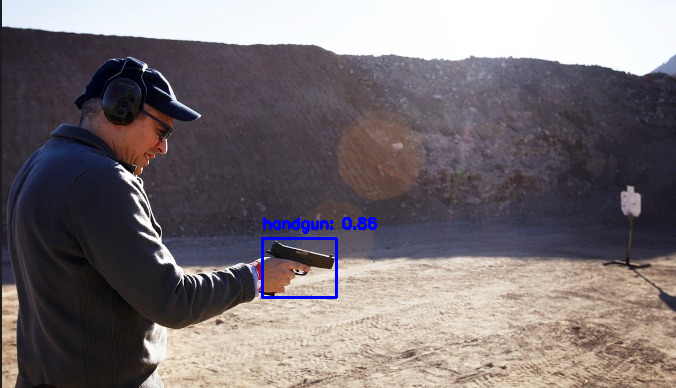

In [ ]:
import cv2
import torch
import numpy as np
from IPython.display import display, Image, Video
from google.colab.patches import cv2_imshow
from super_gradients.training import models
import os

def load_model(model_path, num_classes):
    try:
        # Convert to absolute path if it's not already
        abs_model_path = os.path.abspath(model_path)

        if not os.path.exists(abs_model_path):
            raise FileNotFoundError(f"Model file not found: {abs_model_path}")

        model = models.get('yolo_nas_l', num_classes=num_classes, checkpoint_path=abs_model_path)
        model.eval()
        print(f"Model loaded successfully from {abs_model_path}")
        return model
    except FileNotFoundError as e:
        print(f"Error: {str(e)}")
        print("Please check if the file exists and you have the correct permissions.")
    except Exception as e:
        print(f"Error loading the model: {str(e)}")
        print("Please ensure you're using the correct model path and have the required permissions.")
    return None


def process_image(model, image_path, classes):
    # Read the image
    image = cv2.imread(image_path)

    # Perform inference
    with torch.no_grad():
        predictions = model.predict(image)

    pred_boxes = predictions.prediction.bboxes_xyxy
    pred_labels = predictions.prediction.labels
    pred_scores = predictions.prediction.confidence

    # Draw predicted boxes
    for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
        x1, y1, x2, y2 = map(int, box)
        class_name = classes[int(label)]
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        label_text = f"{class_name}: {score:.2f}"
        cv2.putText(image, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    return image

def process_video(model, video_path, classes, output_path):
    cap = cv2.VideoCapture(video_path)

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Perform inference
        with torch.no_grad():
            predictions = model.predict(frame)

        pred_boxes = predictions.prediction.bboxes_xyxy
        pred_labels = predictions.prediction.labels
        pred_scores = predictions.prediction.confidence

        # Draw predicted boxes
        for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
            x1, y1, x2, y2 = map(int, box)
            class_name = classes[int(label)]
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
            label_text = f"{class_name}: {score:.2f}"
            cv2.putText(frame, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        out.write(frame)

    cap.release()
    out.release()

    return output_path

def display_image(image_path):
    display(Image(filename=image_path))

def display_video(video_path):
    display(Video(video_path))

# User functions
def process_user_image(model_path, image_path, classes):
    model = load_model(model_path, len(classes))
    if model is None:
        return

    processed_image = process_image(model, image_path, classes)
    cv2_imshow(processed_image)

def process_user_video(model_path, video_path, output_path, classes):
    model = load_model(model_path, len(classes))
    if model is None:
        return

    processed_video_path = process_video(model, video_path, classes, output_path)
    print(f"Processed video saved to: {processed_video_path}")
    display_video(processed_video_path)

# Example usage:
MODEL_PATH = '/content/drive/MyDrive/ckpt_best.pth'
CLASSES = ['handgun', 'knife']

process_user_image(MODEL_PATH, '/content/demo 1.jpg', CLASSES)

##Video

In [ ]:
import cv2
import torch
import numpy as np
from IPython.display import display, Image, Video
from google.colab.patches import cv2_imshow
from super_gradients.training import models
import os

def load_model(model_path, num_classes):
    try:
        # Convert to absolute path if it's not already
        abs_model_path = os.path.abspath(model_path)

        if not os.path.exists(abs_model_path):
            raise FileNotFoundError(f"Model file not found: {abs_model_path}")

        model = models.get('yolo_nas_l', num_classes=num_classes, checkpoint_path=abs_model_path)
        model.eval()
        print(f"Model loaded successfully from {abs_model_path}")
        return model
    except FileNotFoundError as e:
        print(f"Error: {str(e)}")
        print("Please check if the file exists and you have the correct permissions.")
    except Exception as e:
        print(f"Error loading the model: {str(e)}")
        print("Please ensure you're using the correct model path and have the required permissions.")
    return None


def process_image(model, image_path, classes):
    # Read the image
    image = cv2.imread(image_path)

    # Perform inference
    with torch.no_grad():
        predictions = model.predict(image)

    pred_boxes = predictions.prediction.bboxes_xyxy
    pred_labels = predictions.prediction.labels
    pred_scores = predictions.prediction.confidence

    # Draw predicted boxes
    for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
        x1, y1, x2, y2 = map(int, box)
        class_name = classes[int(label)]
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        label_text = f"{class_name}: {score:.2f}"
        cv2.putText(image, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    return image

def process_video(model, video_path, classes, output_path):
    cap = cv2.VideoCapture(video_path)

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Perform inference
        with torch.no_grad():
            predictions = model.predict(frame)

        pred_boxes = predictions.prediction.bboxes_xyxy
        pred_labels = predictions.prediction.labels
        pred_scores = predictions.prediction.confidence

        # Draw predicted boxes
        for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
            x1, y1, x2, y2 = map(int, box)
            class_name = classes[int(label)]
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
            label_text = f"{class_name}: {score:.2f}"
            cv2.putText(frame, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        out.write(frame)

    cap.release()
    out.release()

    return output_path

def display_image(image_path):
    display(Image(filename=image_path))

def display_video(video_path):
    display(Video(video_path))

# User functions
def process_user_image(model_path, image_path, classes):
    model = load_model(model_path, len(classes))
    if model is None:
        return

    processed_image = process_image(model, image_path, classes)
    cv2_imshow(processed_image)

def process_user_video(model_path, video_path, output_path, classes):
    model = load_model(model_path, len(classes))
    if model is None:
        return

    processed_video_path = process_video(model, video_path, classes, output_path)
    print(f"Processed video saved to: {processed_video_path}")
    display_video(processed_video_path)

# Example usage:
MODEL_PATH = '/content/drive/MyDrive/ckpt_best.pth'
CLASSES = ['handgun', 'knife']
process_user_video(MODEL_PATH, '/content/demo check.mp4', 'video.mp4', CLASSES)

[2024-07-26 08:15:52] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/drive/MyDrive/ckpt_best.pth EMA checkpoint.
[2024-07-26 08:15:52] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


Model loaded successfully from /content/drive/MyDrive/ckpt_best.pth


[2024-07-26 08:16:02] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-07-26 08:16:07] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-07-26 08:16:14] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-07-26 08:16:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-07-26 08:16:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-07-26 08:16:31] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-07-26 08:16:37] INFO -